In [ ]:
# Update 10/29/2021. Use fragments.tsv.gz (no duplicates) instead of .bam
# Update 10/7/2021. Random regions are drawn from ecDNA regions from other MBs.
# Experiment: ran featurecounts across all cells in RCMB56-ht (~5k), for each counting read coverage at 1000 
# randomly permuted 1Mb genomic regions.

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from statsmodels.stats.multitest import multipletests
#from statsmodels.discrete.discrete_model import NegativeBinomial
from matplotlib_venn import *

%matplotlib inline
pd.set_option('display.max_rows', 30)

import sys
sys.path.append("/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/src")
from SingleCellExperiment import *

In [11]:
def load_counts(file, ecDNA_len):
    '''
    returns: series
    index: barcode
    '''
    s = pd.read_csv(file,sep='\t',index_col=0)
    s = select_qc_passed_cells(s)
    s /= ecDNA_len
    return s.squeeze()

def load_backgrounds(file):
    '''
    returns: dataframe
    rows: barcodes
    column: random permutation region
    access as df[barcode.bam]
    '''
    df = pd.read_csv(file,sep='\t',index_col=0)
    df = select_qc_passed_cells(df)
    return df

def select_qc_passed_cells(df):
    '''
    Returns df subsetted to include only rows passing seurat qc.
    '''
    master = SAMPLE
    m=master.df[master.df['qc_pass_seurat']]
    df=df[df.index.isin(m.index)]
    return df
    
def estimate_pvalues(observed,backgrounds):
    # Set up dataframe of observed featurecounts    
    df = pd.DataFrame(observed)
    df.columns=['Observed']
    
    # Estimate empirical p
    bg=backgrounds
    df['empirical p-val']=observed.index.map(lambda x: ((observed[x] <= bg.loc[x]).sum()+1) / (len(bg.loc[x])+1))
    
    # Sample standard deviation
    df['z-score']=observed.index.map(lambda x: abs(observed[x] - bg.loc[x].mean())/bg.loc[x].std())
    
    return df

def gen_histograms(observed,backgrounds,outfile_prefix=None):
    w=6
    h=6
    df = estimate_pvalues(observed,bg)
    observed=observed.loc[df.index]
    backgrounds=backgrounds.loc[df.index]
    fig,axes = plt.subplots(h,w, figsize=(20,20))
    for i in range(h*w):
        sns.histplot(ax=axes[i//h,i%h],data=backgrounds.iloc[i,:],binwidth=1)
        # observed value
        axes[i//h,i%h].axvline(df.iloc[i,0],c='red')
        text = 'empirical p<'+str(round(df.iloc[i,1],3))
        axes[i//h,i%h].text(0.9,0.8,text,horizontalalignment='right',transform=axes[i//h,i%h].transAxes)
    if outfile_prefix != None:
        fig.savefig(outfile_prefix+'.svg')
        fig.savefig(outfile_prefix+'.png')
        
def classify(fgs,bg):
    classifications = pd.DataFrame()
    for i in range(len(fgs[0:])):
        df = estimate_pvalues(fgs[i],bg)
        e = multipletests(df['empirical p-val'],alpha=0.10,method='fdr_bh')
        base='ecDNA'+str(i+1)
        classifications[base+"_z-score"] = df['z-score']
        classifications[base+"_p-val"] = df['empirical p-val']
        classifications[base+"_q-val"] = e[1]
        classifications[base+"_status"] = e[0]
        #classifications[base+"_status"] = (df < 0.05)
    return classifications

def summary_venn3(df,out_prefix=None):
    _000 = df[~df.ecDNA1_status & ~df.ecDNA2_status & ~df.ecDNA3_status]
    _001 = df[~df.ecDNA1_status & ~df.ecDNA2_status & df.ecDNA3_status]
    _010 = df[~df.ecDNA1_status & df.ecDNA2_status & ~df.ecDNA3_status]
    _100 = df[df.ecDNA1_status & ~df.ecDNA2_status & ~df.ecDNA3_status]
    _101 = df[df.ecDNA1_status & ~df.ecDNA2_status & df.ecDNA3_status]
    _110 = df[df.ecDNA1_status & df.ecDNA2_status & ~df.ecDNA3_status]
    _011 = df[~df.ecDNA1_status & df.ecDNA2_status & df.ecDNA3_status]
    _111 = df[df.ecDNA1_status & df.ecDNA2_status & df.ecDNA3_status]

    subsets = (len(_100),len(_010),len(_110),len(_001),len(_101),len(_011),len(_111),len(_000))
    plt.figure()
    venn3_unweighted(subsets[:-1],set_labels=['ecDNA1','ecDNA2','ecDNA3'],alpha=0.5)
    if out_prefix != None:
        plt.savefig(out_prefix+' venn.svg')
        plt.savefig(out_prefix+' venn.png')
    return subsets


In [ ]:
# COLO320HSR
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
SAMPLE=None
fg1 = load_counts('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320HSR/COLO320HSR_ecDNA0.tsv',2.007952)
bg = load_backgrounds('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320HSR/COLO320HSR_bkgd.tsv')
df=estimate_pvalues(fg1,bg)
gen_histograms(fg1,bg)
c = classify([fg1],bg)
#summary_venn3(c)

In [ ]:
# COLO320DM
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
SAMPLE=None
fg1 = load_counts('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320DM/COLO320DM_ecDNA0.tsv',2.007952)
bg = load_backgrounds('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320DM/COLO320DM_bkgd.tsv')
df=estimate_pvalues(fg1,bg)
gen_histograms(fg1,bg)
c = classify([fg1],bg)
#summary_venn3(c)

In [ ]:
c[c.ecDNA1_status == True]

(152, 20, 82, 0, 0, 0, 0, 2732)

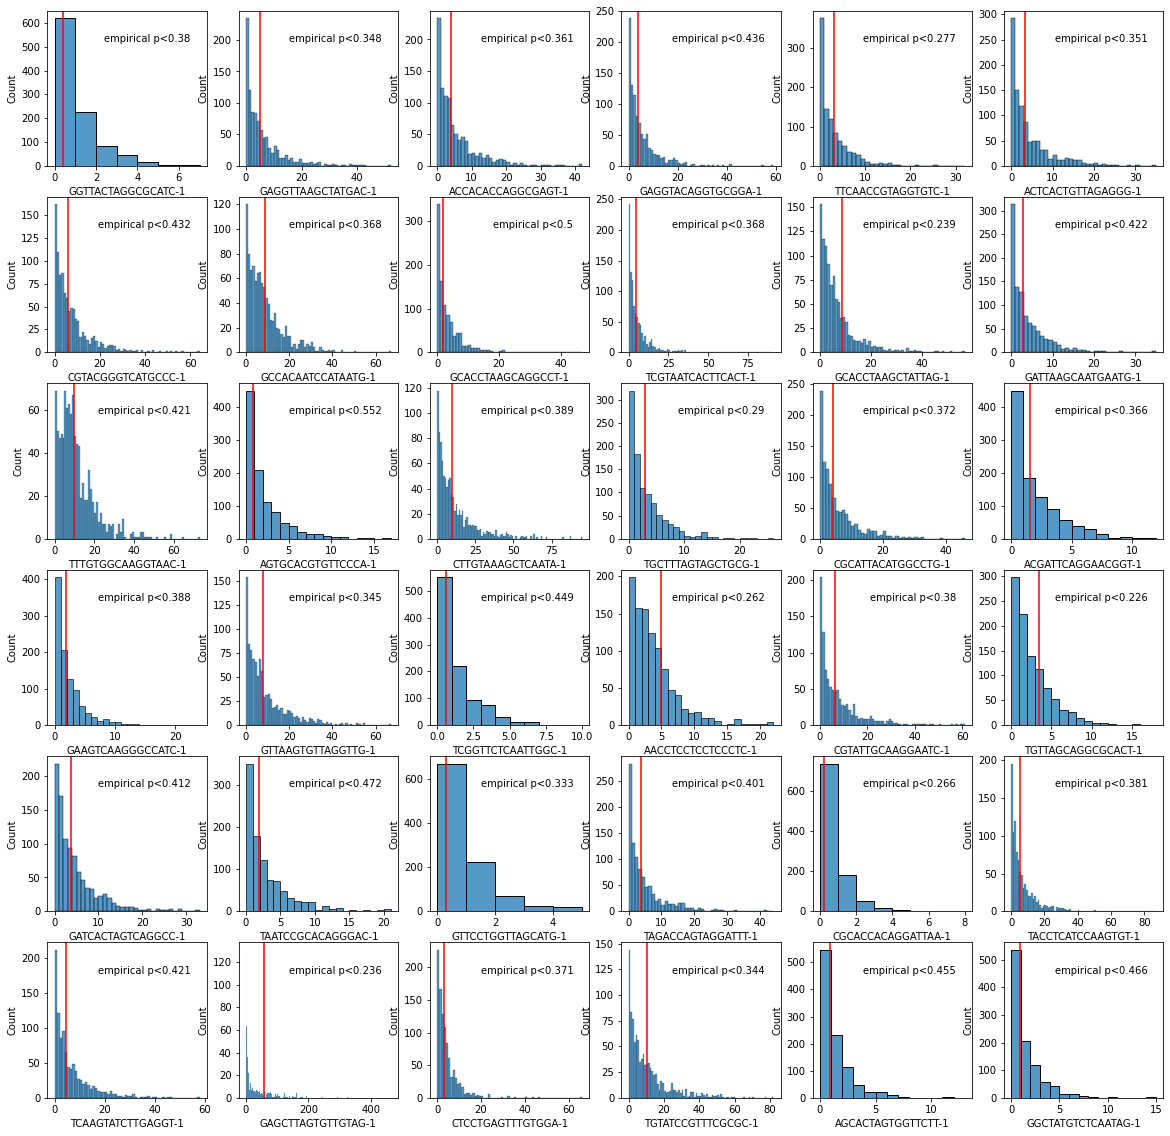

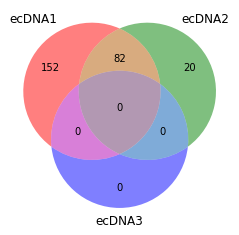

In [12]:
# rcmb56-ht
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
barcodes_file = root+"RCMB56-ht/cellranger-2.0.0/outs/filtered_feature_bc_matrix/barcodes.tsv"
seurat_file = root+"2021-08-29_seurat/rcmb56-ht_seurat_metadata.tsv"
SAMPLE=SingleCellExperiment(barcodes_file,seurat_file)

fg1 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_ecDNA1.tsv',3.177119)
fg2 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_ecDNA2.tsv',4.455655)
fg3 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_ecDNA3.tsv',35.231882)
bg = load_backgrounds('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_bkgd.tsv')
#df=estimate_pvalues(fg1,bg)
gen_histograms(fg3,bg)
c = classify([fg1,fg2,fg3],bg)
#c = classify([fg1,fg2],bg)
summary_venn3(c)

In [ ]:
bg

In [ ]:
# rcmb56-ht, misclassified cells.
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
barcodes_file = root+"RCMB56-ht/cellranger-2.0.0/outs/filtered_feature_bc_matrix/barcodes.tsv"
seurat_file = root+"2021-08-29_seurat/rcmb56-ht_seurat_metadata.tsv"
SAMPLE=SingleCellExperiment(barcodes_file,seurat_file)


fg1 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_ecDNA1.tsv',3.177119)
bg = load_backgrounds('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-ht_bkgd.tsv')
misclassified = ['ATTGCGCCATTGTGGC-1','TGTTCCTCACCTCACC-1']
fg1 = fg1.loc[misclassified]
bg = bg.loc[misclassified]
bg
df=estimate_pvalues(fg1,bg)
gen_histograms(fg1,bg)
df

In [ ]:
# rcmb56-pdx
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
barcodes_file = root+"RCMB56-pdx/RCMB56-pdx/outs/filtered_feature_bc_matrix/barcodes.tsv"
seurat_file = root+"2021-08-29_seurat/rcmb56-pdx_seurat_metadata.tsv"
SAMPLE=SingleCellExperiment(barcodes_file,seurat_file)

fg1 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-pdx_ecDNA1.tsv',3.177119)
fg2 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-pdx_ecDNA2.tsv',4.455655)
fg3 = load_counts('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-pdx_ecDNA3.tsv',35.231882)
bg = load_backgrounds('/home/ochapman/expanse/projects/scRNA+ATAC/2021-10-18_fragments-tsv-gz/outs/rcmb56-pdx_ec_bkgd.tsv')
df=estimate_pvalues(fg1,bg)
gen_histograms(fg1,bg)
c = classify([fg1,fg2,fg3],bg)
#c = classify([fg1,fg2],bg)
summary_venn3(c)
c

In [ ]:
bg.iloc[1].std()

In [ ]:
c.to_csv("ecDNA_status_ebg.tsv",sep='\t')

## Scratch

In [ ]:
observed = parse_featurecounts_to_series('inputs/ht_case11_ecDNA_1_counts.txt.summary')
bg = load_backgrounds('inputs/featurecounts-permutations-ht.tsv')

# Set up dataframe of observed featurecounts    
df = pd.DataFrame(observed)
df.columns=['Observed']

# Estimate empirical p
df['empirical p-val']=observed.index.map(lambda x: ((observed[x] <= bg.loc[x]).sum()+1) / (len(bg.loc[x])+1))

# load master table
mt=pd.read_csv("../rcmb56-ht_master_table.tsv",sep='\t',index_col=0)
mt=mt['empirical p-val_ecDNA1']
df=df.join(mt)
# compare p-value distributions

## Something's fucked, my p-values are all lower.
## (checked the bg files, I have way more zeroes in the ecDNA-only bg. Stats code is clean then.)
## Checking the regions themselves, looks like they do indeed come from ecDNA loci...
## Found it. looks like over half of my bed files are hg19.
## 10/11/2021 - corrected the hg19 bug, but problem persists
## Assigned features in tables match assigned features in .summary files
## Why are there so fewer assigned features in the revised permuted regions??
## Sums of assigned features and unassigned_nofeatures are equal across both new and old permutation runs; reads are not being assigned features.
## There are most certainly reads mapping to eg GLI2, yet the featurecounts output reports no mapped reads to 
##  the locus chr2:120320650-121320649.
## Solved. Featurecounts default behavior is to arbitrarily map a read to 1 region in case of overlapping reads.
## NB: this means we've saturated our sampling space, because the GLI2 locus and all others at the end of the fc file had 
##  zero counts.

df

In [ ]:
df[df["empirical p-val"]<0.05]

In [ ]:
old_bg=load_backgrounds('../2021-08-17_featurecounts-permutation-2/featurecounts-permutations-ht-old.tsv')
old_bg.apply(sum,axis=0)

In [ ]:
bg.apply(sum,axis=0)

In [ ]:
def summary_venn3(df,out_prefix):
    _000 = df[~df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _001 = df[~df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _010 = df[~df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _100 = df[df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _101 = df[df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _110 = df[df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _011 = df[~df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    _111 = df[df.ecDNA1 & df.ecDNA2 & df.ecDNA3]

    subsets = (len(_100),len(_010),len(_110),len(_001),len(_101),len(_011),len(_111),len(_000))
    plt.figure()
    venn3_unweighted(subsets[:-1],set_labels=['ecDNA1','ecDNA2','ecDNA3'],alpha=0.5)
    plt.savefig(out_prefix+' venn.svg')
    plt.savefig(out_prefix+' venn.png')

def summary_venn2(df,out_prefix):
    plt.figure()
    _00 = df[~df.ecDNA1 & ~df.ecDNA2]
    _01 = df[~df.ecDNA1 & df.ecDNA2]
    _10 = df[df.ecDNA1 & ~df.ecDNA2]
    _11 = df[df.ecDNA1 & df.ecDNA2]
    subsets = (len(_10),len(_01),len(_11),len(_00))
    print(subsets)
    venn2(subsets[:-1],set_labels=['ecDNA1','ecDNA2'],alpha=0.5)
    plt.savefig(out_prefix+' venn.svg')
    plt.savefig(out_prefix+' venn.png')
    
def plot_upset(df,out_prefix):
    # data = upsetplot.from_indicators(df) # from_indicators is bugged, hardcode for now.
    _000 = df[~df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _001 = df[~df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _010 = df[~df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _100 = df[df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _101 = df[df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _110 = df[df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _011 = df[~df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    _111 = df[df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    data = upsetplot.from_memberships(
        [[],
         ['ecDNA1'],
         ['ecDNA2'],
         ['ecDNA3'],
         ['ecDNA1','ecDNA2'],
         ['ecDNA1','ecDNA3'],
         ['ecDNA2','ecDNA3'],
         ['ecDNA1','ecDNA2','ecDNA3']
        ],
        data=[len(_000),len(_100),len(_010),len(_001),len(_110),len(_101),len(_011),len(_111)]
    )
    plt.figure()
    upsetplot.plot(data)
    plt.savefig(out_prefix+' upset.svg')
    plt.savefig(out_prefix+' upset.png')
    return data

In [ ]:
# Run RCMB56-ht
fg1 = parse_featurecounts_to_series('inputs/ht_case11_ecDNA_1_counts.txt.summary')
bg = load_backgrounds('inputs/featurecounts-permutations-ht.tsv')
#df = fit_poisson(fg1,bg)
gen_histograms(fg1,bg,'single cell ecDNA detection RCMB56-ht ecDNA1')
#fg2 = load_features('RCMB56-ht.tsv','ecDNA2')
fg2 = parse_featurecounts_to_series('inputs/ht_case11_ecDNA_2_counts.txt.summary')
fg3 = parse_featurecounts_to_series('inputs/ht_RCMB56_ecDNA_3_counts.txt.summary')
#fg3 = load_features('RCMB56-ht.tsv','ecDNA3')
df = classify([fg1,fg2,fg3],bg)
df.to_csv('RCMB56-ht_cell-classifications.tsv',sep='\t')
plot_upset(df,'RCMB56-ht')
summary_venn3(df,'RCMB56-ht')
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-ht_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-ht_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-ht_ecDNA3_poisson.tsv",sep='\t')

In [ ]:
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-pdx_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-pdx_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-pdx_ecDNA3_poisson.tsv",sep='\t')


In [ ]:
# Run RCMB56-pdx
fg1 = parse_featurecounts_to_series('inputs/RCMB56-pdx_case11_ecDNA_1_counts.txt.summary')
bg = load_backgrounds('featurecounts-permutations-pdx.tsv')
#df = fit_poisson(fg1,bg)
gen_histograms(fg1,bg,'single cell ecDNA detection RCMB56-ht ecDNA1')
fg2 = parse_featurecounts_to_series('inputs/RCMB56-pdx_case11_ecDNA_2_counts.txt.summary')
fg3 = parse_featurecounts_to_series('inputs/RCMB56-pdx_RCMB56_ecDNA_3_counts.txt.summary')
df = classify([fg1,fg2,fg3],bg)
df.to_csv('RCMB56-pdx_cell-classifications.tsv',sep='\t')
#summary_venn2(df,'RCMB56-pdx')
plot_upset(df,'RCMB56-pdx')
summary_venn3(df,'RCMB56-pdx')
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-pdx_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-pdx_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-pdx_ecDNA3_poisson.tsv",sep='\t')

In [ ]:
df